Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.2MB/s]


Epoch 1: VAE Train Loss 178.74, Test Loss 136.10 | AE Train Loss 149.25
Epoch 2: VAE Train Loss 130.58, Test Loss 119.46 | AE Train Loss 93.11
Epoch 3: VAE Train Loss 120.78, Test Loss 112.85 | AE Train Loss 81.46
Epoch 4: VAE Train Loss 114.96, Test Loss 106.65 | AE Train Loss 75.72
Epoch 5: VAE Train Loss 111.14, Test Loss 103.79 | AE Train Loss 72.21
Epoch 6: VAE Train Loss 108.77, Test Loss 101.89 | AE Train Loss 70.09
Epoch 7: VAE Train Loss 107.18, Test Loss 101.27 | AE Train Loss 68.74
Epoch 8: VAE Train Loss 105.96, Test Loss 99.78 | AE Train Loss 67.77
Epoch 9: VAE Train Loss 105.01, Test Loss 99.89 | AE Train Loss 67.05
Epoch 10: VAE Train Loss 104.22, Test Loss 98.66 | AE Train Loss 66.42
Epoch 11: VAE Train Loss 103.62, Test Loss 97.98 | AE Train Loss 65.90
Epoch 12: VAE Train Loss 103.10, Test Loss 98.04 | AE Train Loss 65.46
Epoch 13: VAE Train Loss 102.63, Test Loss 98.00 | AE Train Loss 65.06
Epoch 14: VAE Train Loss 102.23, Test Loss 97.41 | AE Train Loss 64.73
Epoch 1

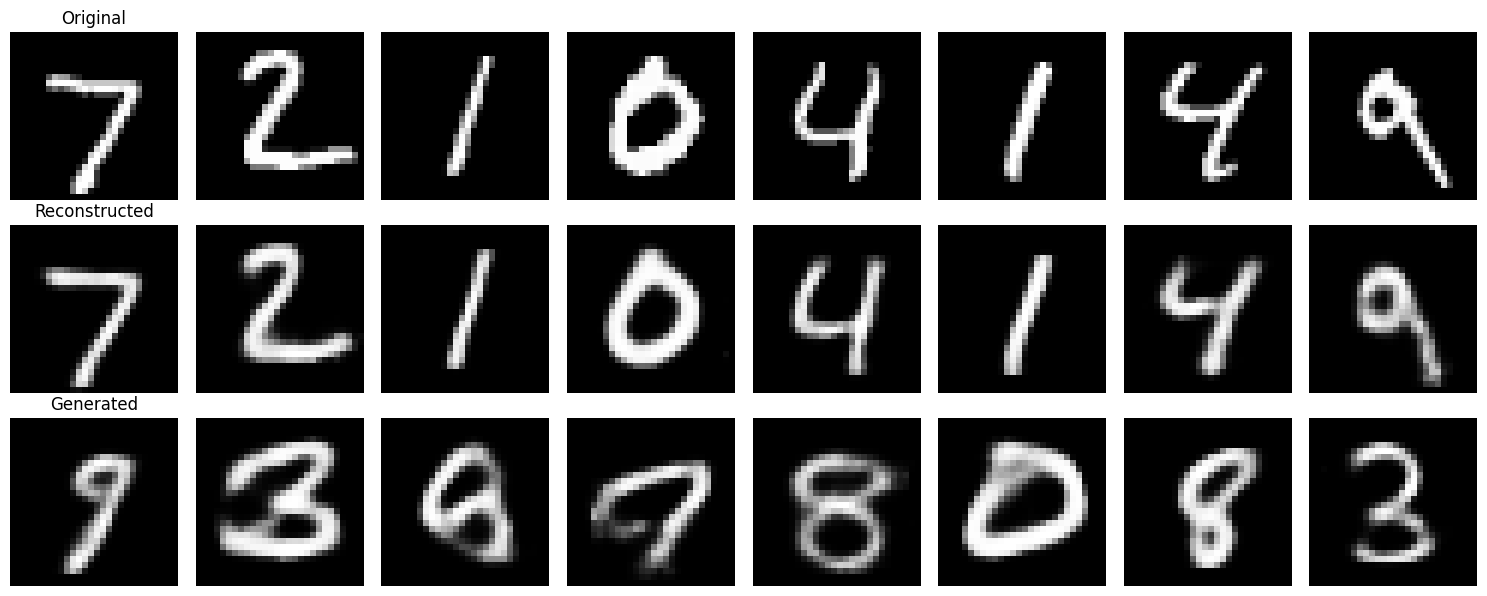

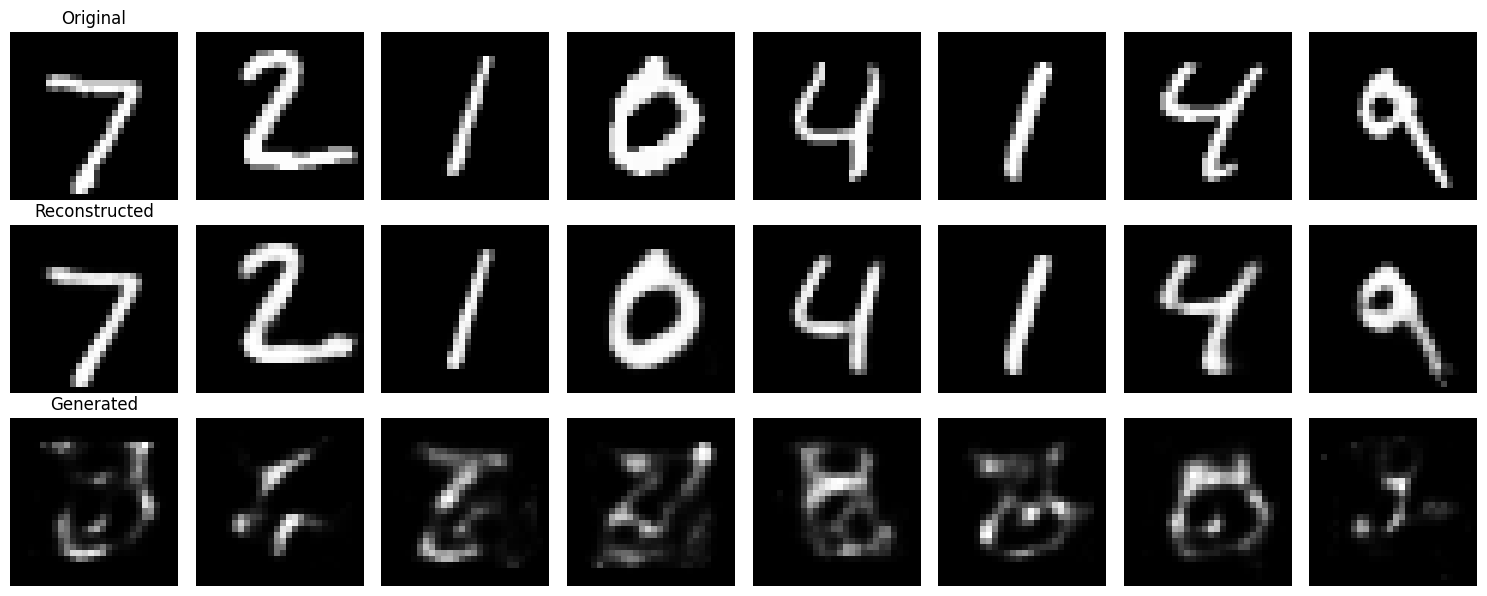

Mean pixel variance: 0.002258, Std: 0.000552


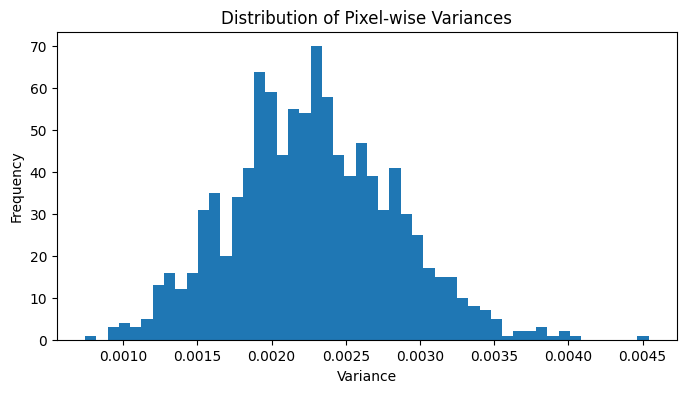

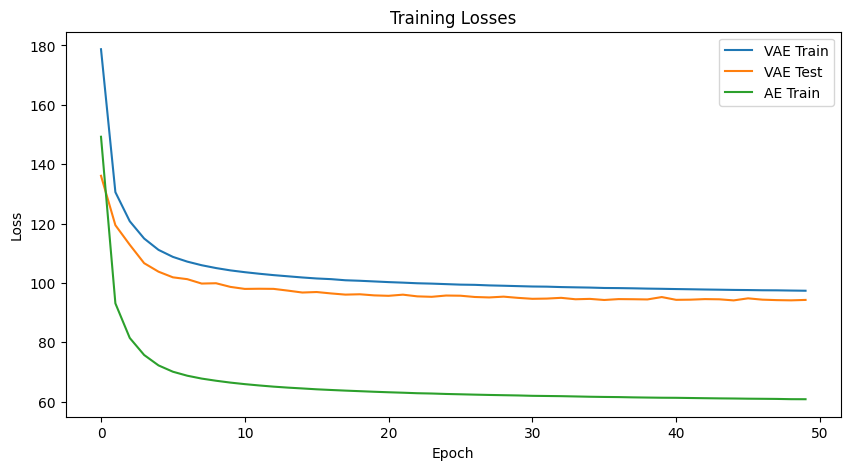


Analysis Summary:
Reconstruction Error (MSE):
VAE: 0.01098
AE: 0.00635

Clustering Metrics:
VAE - ARI: 0.493, NMI: 0.583, Silhouette: 0.101
AE - ARI: 0.499, NMI: 0.597, Silhouette: 0.131

Generative Metrics:
VAE - FID: 5.95, IS: 1.46 ± 0.14
AE - FID: 39.80, IS: 1.45 ± 0.15

Uncertainty Quantification:
VAE - Mean Variance: 0.002268, Std: 0.000558
AE - Mean Variance: 0.000000, Std: 0.000000


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from scipy import linalg
import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class VAE(nn.Module):
    """
    Variational Autoencoder implementing the non-deterministic unsupervised model
    L = E_q(z|x)[log p(x|z)] - βD_KL(q(z|x)||p(z))
    """
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20, beta=1.0):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.beta = beta

        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Latent space parameters
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        """Encode input to latent space parameters"""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar, sample=True):
        """Reparameterization trick for stochastic sampling, with option to force sampling in eval mode"""
        if sample:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def decode(self, z):
        """Decode latent representation to reconstruction"""
        return self.decoder(z)

    def forward(self, x, sample=True):
        """Complete forward pass, with sampling option"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, sample=sample)
        recon = self.decode(z)
        return recon, mu, logvar, z

class DeterministicAutoencoder(nn.Module):
    """Deterministic baseline autoencoder for comparison"""
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(DeterministicAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """VAE loss function: reconstruction + β * KL divergence"""
    # Reconstruction loss
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta * KLD, BCE, KLD

def ae_loss(recon_x, x):
    """AE loss function: reconstruction only"""
    return F.binary_cross_entropy(recon_x, x, reduction='sum')

def train_vae(model, dataloader, optimizer, device, beta=1.0):
    """Training function for VAE"""
    model.train()
    train_loss = 0
    train_recon = 0
    train_kld = 0

    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.view(-1, 784).to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar, _ = model(data)
        loss, recon_loss, kld_loss = vae_loss(recon_batch, data, mu, logvar, beta)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_recon += recon_loss.item()
        train_kld += kld_loss.item()

    avg_loss = train_loss / len(dataloader.dataset)
    avg_recon = train_recon / len(dataloader.dataset)
    avg_kld = train_kld / len(dataloader.dataset)
    return avg_loss, avg_recon, avg_kld

def test_vae(model, dataloader, device):
    """Testing function for VAE"""
    model.eval()
    test_loss = 0
    test_recon = 0
    test_kld = 0

    with torch.no_grad():
        for data, _ in dataloader:
            data = data.view(-1, 784).to(device)
            recon_batch, mu, logvar, _ = model(data, sample=False)  # Deterministic for testing
            loss, recon_loss, kld_loss = vae_loss(recon_batch, data, mu, logvar, model.beta)

            test_loss += loss.item()
            test_recon += recon_loss.item()
            test_kld += kld_loss.item()

    avg_loss = test_loss / len(dataloader.dataset)
    avg_recon = test_recon / len(dataloader.dataset)
    avg_kld = test_kld / len(dataloader.dataset)
    return avg_loss, avg_recon, avg_kld

def train_ae(model, dataloader, optimizer, device):
    """Training function for AE"""
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.view(-1, 784).to(device)
        optimizer.zero_grad()

        recon_batch, _ = model(data)
        loss = ae_loss(recon_batch, data)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(dataloader.dataset)

def test_ae(model, dataloader, device):
    """Testing function for AE"""
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data, _ in dataloader:
            data = data.view(-1, 784).to(device)
            recon_batch, _ = model(data)
            loss = ae_loss(recon_batch, data)

            test_loss += loss.item()

    return test_loss / len(dataloader.dataset)

def get_latent_representations(model, dataloader, device, is_vae=False):
    """Extract latent representations"""
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for data, target in dataloader:
            data = data.view(-1, 784).to(device)
            if is_vae:
                _, _, _, z = model(data, sample=False)  # Use mean for clustering
            else:
                _, z = model(data)
            latents.append(z.cpu().numpy())
            labels.append(target.numpy())

    return np.concatenate(latents), np.concatenate(labels)

def clustering_evaluation(latents, true_labels, n_clusters=10):
    """Evaluate clustering in latent space"""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    pred_labels = kmeans.fit_predict(latents)

    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    silhouette = silhouette_score(latents, pred_labels)

    return ari, nmi, silhouette

def simplified_fid(real_data, gen_data):
    """Simplified Fréchet Inception Distance using raw data statistics"""
    mu1 = np.mean(real_data, axis=0)
    mu2 = np.mean(gen_data, axis=0)

    sigma1 = np.cov(real_data, rowvar=False)
    sigma2 = np.cov(gen_data, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

def simplified_inception_score(gen_data, n_classes=10, eps=1e-6):
    """Simplified Inception Score using marginal probabilities"""
    # Simulate class probabilities with random for illustration (replace with actual if Inception available)
    p_yx = np.random.dirichlet(np.ones(n_classes), size=len(gen_data))
    p_yx = np.clip(p_yx, eps, 1 - eps)
    p_yx /= p_yx.sum(axis=1, keepdims=True)

    p_y = np.mean(p_yx, axis=0)
    kl_div = np.sum(p_yx * (np.log(p_yx) - np.log(p_y)), axis=1)

    is_score = np.exp(np.mean(kl_div))
    is_std = np.std(kl_div)

    return is_score, is_std

def generative_evaluation(model, test_loader, device, num_gen=1000, is_vae=False):
    """Evaluate generative metrics"""
    model.eval()
    real_data = []
    gen_data = []

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, 784).to(device)
            real_data.append(data.cpu().numpy())
            if len(np.concatenate(real_data)) >= num_gen:
                break

    real_data = np.concatenate(real_data)[:num_gen]

    with torch.no_grad():
        batch_size = test_loader.batch_size
        for _ in range((num_gen // batch_size) + 1):
            z = torch.randn(batch_size, model.latent_dim).to(device)
            if is_vae:
                gen_batch = model.decode(z)
            else:
                gen_batch = model.decoder(z)
            gen_data.append(gen_batch.cpu().numpy())
            if len(np.concatenate(gen_data)) >= num_gen:
                break

    gen_data = np.concatenate(gen_data)[:num_gen]

    fid = simplified_fid(real_data, gen_data)
    is_score, is_std = simplified_inception_score(gen_data)

    return fid, is_score, is_std

def reconstruction_error(model, dataloader, device):
    """Compute average MSE reconstruction error"""
    model.eval()
    mse_func = nn.MSELoss(reduction='mean')
    total_mse = 0
    num_samples = 0

    with torch.no_grad():
        for data, _ in dataloader:
            data = data.view(-1, 784).to(device)
            if isinstance(model, VAE):
                recon, _, _, _ = model(data, sample=False)
            else:
                recon, _ = model(data)
            total_mse += mse_func(recon, data).item() * data.size(0)
            num_samples += data.size(0)

    return total_mse / num_samples

def uncertainty_analysis(model, dataloader, device, num_samples=10):
    """Quantify uncertainty via variance in reconstructions"""
    if not isinstance(model, VAE):
        return 0.0, 0.0, []  # Deterministic model has zero uncertainty

    model.eval()
    variances = []

    with torch.no_grad():
        for data, _ in dataloader:
            data = data.view(-1, 784).to(device)
            recons = []

            for _ in range(num_samples):
                recon, _, _, _ = model(data, sample=True)  # Force sampling for uncertainty
                recons.append(recon.unsqueeze(0))

            recons = torch.cat(recons, dim=0)
            var = torch.var(recons, dim=0).mean(dim=1).cpu().numpy()
            variances.extend(var)

            if len(variances) >= 1000:  # Limit for efficiency
                break

    variances = np.array(variances)
    return np.mean(variances), np.std(variances), variances

def visualize_reconstructions(model, data, device, is_vae=False, num_images=8):
    """Visualize original, reconstructed, and generated samples"""
    model.eval()
    with torch.no_grad():
        data = data[:num_images].view(-1, 784).to(device)
        if is_vae:
            recon, _, _, _ = model(data, sample=False)
            z = torch.randn(num_images, model.latent_dim).to(device)
            gen = model.decode(z)
        else:
            recon, _ = model(data)
            z = torch.randn(num_images, model.latent_dim).to(device)
            gen = model.decoder(z)

    fig, axes = plt.subplots(3, num_images, figsize=(15, 6))

    for i in range(num_images):
        axes[0, i].imshow(data[i].view(28, 28).cpu().numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon[i].view(28, 28).cpu().numpy(), cmap='gray')
        axes[1, i].axis('off')
        axes[2, i].imshow(gen[i].view(28, 28).cpu().numpy(), cmap='gray')
        axes[2, i].axis('off')

    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstructed')
    axes[2, 0].set_title('Generated')
    plt.tight_layout()
    plt.show()

def visualize_uncertainty(model, dataloader, device, num_samples=10):
    """Visualize uncertainty histogram"""
    if not isinstance(model, VAE):
        print("Deterministic model has zero uncertainty.")
        return

    mean_var, std_var, _ = uncertainty_analysis(model, dataloader, device, num_samples)
    print(f"Mean pixel variance: {mean_var:.6f}, Std: {std_var:.6f}")

    # Histogram
    _, _, variances = uncertainty_analysis(model, dataloader, device, num_samples)
    plt.figure(figsize=(8, 4))
    plt.hist(variances, bins=50)
    plt.title('Distribution of Pixel-wise Variances')
    plt.xlabel('Variance')
    plt.ylabel('Frequency')
    plt.show()

def visualize_losses(vae_losses, ae_losses):
    """Plot training losses"""
    plt.figure(figsize=(10, 5))
    plt.plot(vae_losses['train'], label='VAE Train')
    plt.plot(vae_losses['test'], label='VAE Test')
    plt.plot(ae_losses['train'], label='AE Train')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Losses')
    plt.show()

# Main execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Initialize models
vae = VAE(beta=1.0).to(device)
ae = DeterministicAutoencoder().to(device)

# Optimizers
vae_optimizer = optim.Adam(vae.parameters(), lr=1e-3)
ae_optimizer = optim.Adam(ae.parameters(), lr=1e-3)

# Training loop
epochs = 50
vae_train_losses = []
vae_test_losses = []
ae_train_losses = []

for epoch in range(1, epochs + 1):
    vae_train_loss, _, _ = train_vae(vae, train_loader, vae_optimizer, device)
    vae_test_loss, _, _ = test_vae(vae, test_loader, device)
    ae_train_loss = train_ae(ae, train_loader, ae_optimizer, device)

    vae_train_losses.append(vae_train_loss)
    vae_test_losses.append(vae_test_loss)
    ae_train_losses.append(ae_train_loss)

    print(f"Epoch {epoch}: VAE Train Loss {vae_train_loss:.2f}, Test Loss {vae_test_loss:.2f} | AE Train Loss {ae_train_loss:.2f}")

# Evaluations
vae_latents, true_labels = get_latent_representations(vae, test_loader, device, is_vae=True)
ae_latents, _ = get_latent_representations(ae, test_loader, device, is_vae=False)

vae_ari, vae_nmi, vae_sil = clustering_evaluation(vae_latents, true_labels)
ae_ari, ae_nmi, ae_sil = clustering_evaluation(ae_latents, true_labels)

vae_fid, vae_is, vae_is_std = generative_evaluation(vae, test_loader, device, is_vae=True)
ae_fid, ae_is, ae_is_std = generative_evaluation(ae, test_loader, device, is_vae=False)

vae_mse = reconstruction_error(vae, test_loader, device)
ae_mse = reconstruction_error(ae, test_loader, device)

vae_mean_var, vae_std_var, _ = uncertainty_analysis(vae, test_loader, device)
ae_mean_var, ae_std_var, _ = uncertainty_analysis(ae, test_loader, device)

# Visualizations
data_iter = iter(test_loader)
images, _ = next(data_iter)
visualize_reconstructions(vae, images, device, is_vae=True)
visualize_reconstructions(ae, images, device, is_vae=False)

visualize_uncertainty(vae, test_loader, device)

visualize_losses({'train': vae_train_losses, 'test': vae_test_losses}, {'train': ae_train_losses})

# Analysis Summary
print("\nAnalysis Summary:")
print("Reconstruction Error (MSE):")
print(f"VAE: {vae_mse:.5f}")
print(f"AE: {ae_mse:.5f}")

print("\nClustering Metrics:")
print(f"VAE - ARI: {vae_ari:.3f}, NMI: {vae_nmi:.3f}, Silhouette: {vae_sil:.3f}")
print(f"AE - ARI: {ae_ari:.3f}, NMI: {ae_nmi:.3f}, Silhouette: {ae_sil:.3f}")

print("\nGenerative Metrics:")
print(f"VAE - FID: {vae_fid:.2f}, IS: {vae_is:.2f} ± {vae_is_std:.2f}")
print(f"AE - FID: {ae_fid:.2f}, IS: {ae_is:.2f} ± {ae_is_std:.2f}")

print("\nUncertainty Quantification:")
print(f"VAE - Mean Variance: {vae_mean_var:.6f}, Std: {vae_std_var:.6f}")
print(f"AE - Mean Variance: {ae_mean_var:.6f}, Std: {ae_std_var:.6f}")

